# 04 - Allen2022 fMRI Benchmark Smoke Test (Volumetric)

Score AlexNet on both the **8-subject** (515 images) and **4-subject** (~1000 images)
volumetric fMRI benchmarks.

**Sections:**
1. Load and verify assemblies (both variants)
2. Verify benchmark registration (16 benchmarks)
3. Score AlexNet (ridge + RSA, both variants)
4. Assembly visualizations
5. Summary

Registry identifiers:
- `Allen2022_fmri.{V1,V2,V4,IT}-{ridge,rdm}` -- 8-subject
- `Allen2022_fmri_4subj.{V1,V2,V4,IT}-{ridge,rdm}` -- 4-subject

**Environment:** `conda activate vision-2026`

In [1]:
import sys
sys.path.insert(0, '/Users/kartik/Brain-Score 2026/vision')
sys.path.insert(0, '/Users/kartik/Brain-Score 2026/core')

import time
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path

from brainscore_vision import load_model, load_benchmark

ASSEMBLY_DIR = Path('/Volumes/Hagibis/nsd/brainscore')
REGIONS = ['V1', 'V2', 'V4', 'IT']
VARIANTS = {'8-subject': '_8subj', '4-subject': '_4subj'}
BENCHMARK_PREFIXES = {
    '8-subject': 'Allen2022_fmri',
    '4-subject': 'Allen2022_fmri_4subj',
}

/Users/kartik/Brain-Score 2026/core/brainscore_core/metrics/__init__.py:16: FutureWarning: xarray subclass Score should explicitly define __slots__
  class Score(DataAssembly):


## 1. Load and Verify Assemblies

In [2]:
assemblies = {}
for label, suffix in VARIANTS.items():
    train = xr.open_dataarray(str(ASSEMBLY_DIR / f'Allen2022_fmri_train{suffix}.nc'))
    train.load()
    test = xr.open_dataarray(str(ASSEMBLY_DIR / f'Allen2022_fmri_test{suffix}.nc'))
    test.load()
    assemblies[label] = {'train': train, 'test': test}

print('Volumetric Assembly Comparison')
print('=' * 70)
print(f'{"Property":<30s}  {"8-Subject":>15s}  {"4-Subject":>15s}')
print('-' * 70)

for prop, fn in [
    ('Subjects', lambda v: len(np.unique(assemblies[v]['train'].coords['subject'].values))),
    ('Train shape', lambda v: str(assemblies[v]['train'].shape)),
    ('Test shape', lambda v: str(assemblies[v]['test'].shape)),
    ('Train images', lambda v: assemblies[v]['train'].sizes['presentation']),
    ('Test images (unique)', lambda v: len(set(assemblies[v]['test'].coords['stimulus_id'].values))),
    ('Total neuroids', lambda v: assemblies[v]['train'].sizes['neuroid']),
]:
    v8 = fn('8-subject')
    v4 = fn('4-subject')
    print(f'{prop:<30s}  {str(v8):>15s}  {str(v4):>15s}')

# Verify no train/test overlap
for label in VARIANTS:
    train_stims = set(assemblies[label]['train'].coords['stimulus_id'].values)
    test_stims = set(assemblies[label]['test'].coords['stimulus_id'].values)
    assert len(train_stims & test_stims) == 0, f'{label}: train/test overlap!'
    total = len(train_stims | test_stims)
    print(f'\n{label}: train/test overlap=0 (verified), total images={total}')

Volumetric Assembly Comparison
Property                              8-Subject        4-Subject
----------------------------------------------------------------------
Subjects                                      8                4
Train shape                     (412, 84564, 1)  (800, 40314, 1)
Test shape                      (309, 84564, 1)  (600, 40314, 1)
Train images                                412              800
Test images (unique)                        103              200
Total neuroids                            84564            40314

8-subject: train/test overlap=0 (verified), total images=515

4-subject: train/test overlap=0 (verified), total images=1000


In [3]:
train_8s = assemblies['8-subject']['train']
train_4s = assemblies['4-subject']['train']

print('Per-region neuroid counts and noise ceilings')
print(f'{"Region":>6s}  {"8s Neuroids":>12s}  {"4s Neuroids":>12s}  '
      f'{"8s NC":>7s}  {"4s NC":>7s}  {"8s Reliable":>12s}  {"4s Reliable":>12s}')
print('-' * 85)

for region in REGIONS:
    mask_8 = train_8s.coords['region'].values == region
    mask_4 = train_4s.coords['region'].values == region
    n8, n4 = mask_8.sum(), mask_4.sum()
    nc8 = train_8s.coords['nc_testset'].values[mask_8]
    nc4 = train_4s.coords['nc_testset'].values[mask_4]
    r8, r4 = (nc8 > 30).sum(), (nc4 > 30).sum()
    print(f'{region:>6s}  {n8:>12,}  {n4:>12,}  '
          f'{np.nanmedian(nc8):>6.1f}%  {np.nanmedian(nc4):>6.1f}%  '
          f'{r8:>12,}  {r4:>12,}')

Per-region neuroid counts and noise ceilings
Region   8s Neuroids   4s Neuroids    8s NC    4s NC   8s Reliable   4s Reliable
-------------------------------------------------------------------------------------
    V1         9,039         4,707    37.4%    40.7%         5,402         2,967
    V2         8,792         4,575    31.2%    33.4%         4,584         2,537
    V4         3,982         2,109    25.3%    29.0%         1,660         1,030
    IT        62,751        28,923     7.8%     9.1%        11,744         6,321


## 2. Verify Benchmark Registration

In [4]:
import brainscore_vision.benchmarks.allen2022_fmri
from brainscore_vision import benchmark_registry

for label, prefix in BENCHMARK_PREFIXES.items():
    print(f'{label} benchmarks:')
    for region in REGIONS:
        for metric in ['ridge', 'rdm']:
            key = f'{prefix}.{region}-{metric}'
            assert key in benchmark_registry, f'{key} not registered!'
            print(f'  {key}: registered')
    print()

n_allen = sum(1 for k in benchmark_registry if k.startswith('Allen2022_fmri'))
print(f'Total Allen2022_fmri benchmarks registered: {n_allen}')

8-subject benchmarks:
  Allen2022_fmri.V1-ridge: registered
  Allen2022_fmri.V1-rdm: registered
  Allen2022_fmri.V2-ridge: registered
  Allen2022_fmri.V2-rdm: registered
  Allen2022_fmri.V4-ridge: registered
  Allen2022_fmri.V4-rdm: registered
  Allen2022_fmri.IT-ridge: registered
  Allen2022_fmri.IT-rdm: registered

4-subject benchmarks:
  Allen2022_fmri_4subj.V1-ridge: registered
  Allen2022_fmri_4subj.V1-rdm: registered
  Allen2022_fmri_4subj.V2-ridge: registered
  Allen2022_fmri_4subj.V2-rdm: registered
  Allen2022_fmri_4subj.V4-ridge: registered
  Allen2022_fmri_4subj.V4-rdm: registered
  Allen2022_fmri_4subj.IT-ridge: registered
  Allen2022_fmri_4subj.IT-rdm: registered

Total Allen2022_fmri benchmarks registered: 16


## 3. Score AlexNet

Score all 16 volumetric benchmarks: 4 regions x 2 metrics x 2 subject variants.

In [5]:
model = load_model('alexnet')

METRICS = ['ridge', 'rdm']
results = []

for label, prefix in BENCHMARK_PREFIXES.items():
    for region in REGIONS:
        for metric in METRICS:
            benchmark_id = f'{prefix}.{region}-{metric}'
            print(f'Scoring {benchmark_id}...', end=' ', flush=True)
            t0 = time.time()
            benchmark = load_benchmark(benchmark_id)
            score = benchmark(model)
            elapsed = time.time() - t0
            results.append({
                'benchmark': benchmark_id,
                'variant': label,
                'region': region,
                'metric': metric,
                'raw': float(score.raw),
                'ceiling': float(score.ceiling),
                'normalized': float(score),
            })
            print(f'norm={float(score):.4f}  raw={float(score.raw):.4f}  '
                  f'ceil={float(score.ceiling):.4f}  ({elapsed:.1f}s)')

results_df = pd.DataFrame(results)
print(f'\nScored {len(results_df)} benchmarks.')

/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Scoring Allen2022_fmri.V1-ridge... 

/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 2.6690113230642964e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.41804901])
Coordinates:
  * subject  (subject) <U6 'subj01'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.45093966], dtype=float32)...
    ceiling:  <xarray.Score ()>\narray(0.48641803)\nAttributes:\n    raw:    ...


/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 2.6690113230642964e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.45566256])
Coordinates:
  * subject  (subject) <U6 'subj02'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.5208354], dtype=float32)\...
    ceiling:  <xarray.Score ()>\narray(0.59532982)\nAttributes:\n    raw:    ...


/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 2.6690113230642964e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.44514572])
Coordinates:
  * subject  (subject) <U6 'subj03'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.4456346], dtype=float32)\...
    ceiling:  <xarray.Score ()>\narray(0.44612402)\nAttributes:\n    raw:    ...


/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 2.6690113230642964e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.43944795])
Coordinates:
  * subject  (subject) <U6 'subj04'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.44769052], dtype=float32)...
    ceiling:  <xarray.Score ()>\narray(0.45608769)\nAttributes:\n    raw:    ...


/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 2.6690113230642964e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.29936749])
Coordinates:
  * subject  (subject) <U6 'subj05'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.3855028], dtype=float32)\...
    ceiling:  <xarray.Score ()>\narray(0.4964213)\nAttributes:\n    raw:     ...


/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 2.6690113230642964e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.27058601])
Coordinates:
  * subject  (subject) <U6 'subj06'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.34319466], dtype=float32)...
    ceiling:  <xarray.Score ()>\narray(0.43528702)\nAttributes:\n    raw:    ...


/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 2.6690113230642964e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.43574347])
Coordinates:
  * subject  (subject) <U6 'subj07'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.4742779], dtype=float32)\...
    ceiling:  <xarray.Score ()>\narray(0.51622011)\nAttributes:\n    raw:    ...


/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 2.6690113230642964e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.45152172])
Coordinates:
  * subject  (subject) <U6 'subj08'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.43592086], dtype=float32)...
    ceiling:  <xarray.Score ()>\narray(0.42085905)\nAttributes:\n    raw:    ...
norm=0.4019  raw=0.4380  ceil=0.4803  (6.5s)
Scoring Allen2022_fmri.V1-rdm... 

/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


activations:   0%|          | 0/576 [00:00<?, ?it/s]

layer packaging:   0%|          | 0/1 [00:00<?, ?it/s]

norm=0.4545  raw=0.2539  ceil=0.5586  (5.5s)
Scoring Allen2022_fmri.V2-ridge... 

/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 9.928403699177579e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.406184])
Coordinates:
  * subject  (subject) <U6 'subj01'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.4376764], dtype=float32)\...
    ceiling:  <xarray.Score ()>\narray(0.47161048)\nAttributes:\n    raw:    ...


/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 9.928403699177579e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.39917507])
Coordinates:
  * subject  (subject) <U6 'subj02'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.44736886], dtype=float32)...
    ceiling:  <xarray.Score ()>\narray(0.50138125)\nAttributes:\n    raw:    ...


/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 9.928403699177579e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.44031298])
Coordinates:
  * subject  (subject) <U6 'subj03'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.42434335], dtype=float32)...
    ceiling:  <xarray.Score ()>\narray(0.40895291)\nAttributes:\n    raw:    ...


/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 9.928403699177579e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.49760536])
Coordinates:
  * subject  (subject) <U6 'subj04'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.45404878], dtype=float32)...
    ceiling:  <xarray.Score ()>\narray(0.41430481)\nAttributes:\n    raw:    ...


/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 9.928403699177579e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.3915847])
Coordinates:
  * subject  (subject) <U6 'subj05'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.4169488], dtype=float32)\...
    ceiling:  <xarray.Score ()>\narray(0.4439558)\nAttributes:\n    raw:     ...


/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 9.928403699177579e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.36117103])
Coordinates:
  * subject  (subject) <U6 'subj06'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.38987404], dtype=float32)...
    ceiling:  <xarray.Score ()>\narray(0.42085814)\nAttributes:\n    raw:    ...


/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 9.928403699177579e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.52566788])
Coordinates:
  * subject  (subject) <U6 'subj07'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.49765554], dtype=float32)...
    ceiling:  <xarray.Score ()>\narray(0.47113595)\nAttributes:\n    raw:    ...


/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 9.928403699177579e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.4714326])
Coordinates:
  * subject  (subject) <U6 'subj08'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.44695637], dtype=float32)...
    ceiling:  <xarray.Score ()>\narray(0.42375091)\nAttributes:\n    raw:    ...
norm=0.4366  raw=0.4394  ceil=0.4457  (6.3s)
Scoring Allen2022_fmri.V2-rdm... 

/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


norm=0.3671  raw=0.1933  ceil=0.5266  (2.3s)
Scoring Allen2022_fmri.V4-ridge... 

/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 9.928403699177579e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.37448007])
Coordinates:
  * subject  (subject) <U6 'subj01'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.39834738], dtype=float32)...
    ceiling:  <xarray.Score ()>\narray(0.42373585)\nAttributes:\n    raw:    ...


/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 9.928403699177579e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.47905756])
Coordinates:
  * subject  (subject) <U6 'subj02'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.50740105], dtype=float32)...
    ceiling:  <xarray.Score ()>\narray(0.53742148)\nAttributes:\n    raw:    ...


/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 9.928403699177579e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.33453603])
Coordinates:
  * subject  (subject) <U6 'subj03'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.33000082], dtype=float32)...
    ceiling:  <xarray.Score ()>\narray(0.32552709)\nAttributes:\n    raw:    ...


/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 9.928403699177579e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.23745752])
Coordinates:
  * subject  (subject) <U6 'subj04'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.2938487], dtype=float32)\...
    ceiling:  <xarray.Score ()>\narray(0.36363159)\nAttributes:\n    raw:    ...


/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 9.928403699177579e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.25326535])
Coordinates:
  * subject  (subject) <U6 'subj05'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.33371824], dtype=float32)...
    ceiling:  <xarray.Score ()>\narray(0.439728)\nAttributes:\n    raw:      ...


/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 9.928403699177579e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.21597222])
Coordinates:
  * subject  (subject) <U6 'subj06'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.2773865], dtype=float32)\...
    ceiling:  <xarray.Score ()>\narray(0.35626462)\nAttributes:\n    raw:    ...


/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 9.928403699177579e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.49076643])
Coordinates:
  * subject  (subject) <U6 'subj07'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.47953454], dtype=float32)...
    ceiling:  <xarray.Score ()>\narray(0.4685597)\nAttributes:\n    raw:     ...


/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 9.928403699177579e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


<xarray.Score (subject: 1)>
array([0.39992187])
Coordinates:
  * subject  (subject) <U6 'subj08'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.40743586], dtype=float32)...
    ceiling:  <xarray.Score ()>\narray(0.41509104)\nAttributes:\n    raw:    ...
norm=0.3482  raw=0.3785  ceil=0.4233  (4.6s)
Scoring Allen2022_fmri.V4-rdm... 

/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


norm=0.3281  raw=0.1353  ceil=0.4122  (2.0s)
Scoring Allen2022_fmri.IT-ridge... <xarray.Score (subject: 1)>
array([0.29183699])
Coordinates:
  * subject  (subject) <U6 'subj01'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.3545099], dtype=float32)\...
    ceiling:  <xarray.Score ()>\narray(0.43064199)\nAttributes:\n    raw:    ...
<xarray.Score (subject: 1)>
array([0.27600574])
Coordinates:
  * subject  (subject) <U6 'subj02'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.35484296], dtype=float32)...
    ceiling:  <xarray.Score ()>\narray(0.45619894)\nAttributes:\n    raw:    ...
<xarray.Score (subject: 1)>
array([0.26306193])
Coordinates:
  * subject  (subject) <U6 'subj03'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.3260425], dtype=float32)\...
    ceiling:  <xarray.Score ()>\narray(0.40410148)\nAttributes:\n    raw:    ...
<xarray.Score (subject: 1)>
array([0.31966275])
Coordinates:
  * subject  (subject) <U6 'subj04'
Attributes

/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


activations:   0%|          | 0/576 [00:00<?, ?it/s]

layer packaging:   0%|          | 0/1 [00:00<?, ?it/s]

norm=0.3779  raw=0.3198  ceil=0.8461  (5.5s)
Scoring Allen2022_fmri_4subj.V1-ridge... 

convert image degrees: 100%|██████████| 800/800 [00:01<00:00, 727.60it/s]
/Users/kartik/Brain-Score 2026/vision/brainscore_vision/benchmark_helpers/screen.py:72: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  converted_stimuli.original_paths = copy.deepcopy(stimulus_set.stimulus_paths)


activations:   0%|          | 0/832 [00:00<?, ?it/s]

layer packaging:   0%|          | 0/1 [00:00<?, ?it/s]

convert image degrees: 100%|██████████| 200/200 [00:00<00:00, 706.21it/s]
/Users/kartik/Brain-Score 2026/vision/brainscore_vision/benchmark_helpers/screen.py:72: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  converted_stimuli.original_paths = copy.deepcopy(stimulus_set.stimulus_paths)


activations:   0%|          | 0/256 [00:00<?, ?it/s]

layer packaging:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 3.061870756937424e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.42351334])
Coordinates:
  * subject  (subject) <U6 'subj01'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.4647298], dtype=float32)\...
    ceiling:  <xarray.Score ()>\narray(0.50995743, dtype=float32)\nAttributes...


/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 3.061870756937424e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.45655873])
Coordinates:
  * subject  (subject) <U6 'subj02'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.5345589], dtype=float32)\...
    ceiling:  <xarray.Score ()>\narray(0.6258849, dtype=float32)\nAttributes:...


/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 3.061870756937424e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.37856088])
Coordinates:
  * subject  (subject) <U6 'subj05'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.44330615], dtype=float32)...
    ceiling:  <xarray.Score ()>\narray(0.5191248, dtype=float32)\nAttributes:...


/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 3.061870756937424e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.32743366])
Coordinates:
  * subject  (subject) <U6 'subj07'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.38104832], dtype=float32)...
    ceiling:  <xarray.Score ()>\narray(0.44344196, dtype=float32)\nAttributes...
norm=0.3965  raw=0.4559  ceil=0.5205  (11.1s)
Scoring Allen2022_fmri_4subj.V1-rdm... 

/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


activations:   0%|          | 0/1024 [00:00<?, ?it/s]

layer packaging:   0%|          | 0/1 [00:00<?, ?it/s]

norm=0.5601  raw=0.2513  ceil=0.4486  (9.7s)
Scoring Allen2022_fmri_4subj.V2-ridge... 

activations:   0%|          | 0/832 [00:00<?, ?it/s]

layer packaging:   0%|          | 0/1 [00:00<?, ?it/s]

activations:   0%|          | 0/256 [00:00<?, ?it/s]

layer packaging:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 8.984895316643815e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.46399838])
Coordinates:
  * subject  (subject) <U6 'subj01'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.47736686], dtype=float32)...
    ceiling:  <xarray.Score ()>\narray(0.49112052, dtype=float32)\nAttributes...


/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 8.984895316643815e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.36783967])
Coordinates:
  * subject  (subject) <U6 'subj02'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.4436595], dtype=float32)\...
    ceiling:  <xarray.Score ()>\narray(0.5351075, dtype=float32)\nAttributes:...


/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 8.984895316643815e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.40835684])
Coordinates:
  * subject  (subject) <U6 'subj05'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.43776596], dtype=float32)...
    ceiling:  <xarray.Score ()>\narray(0.46929306, dtype=float32)\nAttributes...


/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 8.984895316643815e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.3918592])
Coordinates:
  * subject  (subject) <U6 'subj07'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.41021934], dtype=float32)...
    ceiling:  <xarray.Score ()>\narray(0.42943972, dtype=float32)\nAttributes...
norm=0.4080  raw=0.4423  ceil=0.4809  (12.1s)
Scoring Allen2022_fmri_4subj.V2-rdm... 

/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


norm=0.4533  raw=0.1888  ceil=0.4166  (3.7s)
Scoring Allen2022_fmri_4subj.V4-ridge... 

/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 8.984895316643815e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.36619517])
Coordinates:
  * subject  (subject) <U6 'subj01'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.3989936], dtype=float32)\...
    ceiling:  <xarray.Score ()>\narray(0.43472967, dtype=float32)\nAttributes...


/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 8.984895316643815e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.39914965])
Coordinates:
  * subject  (subject) <U6 'subj02'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.46392673], dtype=float32)...
    ceiling:  <xarray.Score ()>\narray(0.53921634, dtype=float32)\nAttributes...


/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 8.984895316643815e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.23833028])
Coordinates:
  * subject  (subject) <U6 'subj05'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.32674056], dtype=float32)...
    ceiling:  <xarray.Score ()>\narray(0.44794726, dtype=float32)\nAttributes...


/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:250: LinAlgWarning: An ill-conditioned matrix detected: slice 0 has rcond = 8.984895316643815e-08.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


<xarray.Score (subject: 1)>
array([0.27943407])
Coordinates:
  * subject  (subject) <U6 'subj07'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.35771826], dtype=float32)...
    ceiling:  <xarray.Score ()>\narray(0.45793396, dtype=float32)\nAttributes...
norm=0.3208  raw=0.3868  ceil=0.4679  (4.7s)
Scoring Allen2022_fmri_4subj.V4-rdm... 

/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


norm=0.4259  raw=0.1406  ceil=0.3301  (3.5s)
Scoring Allen2022_fmri_4subj.IT-ridge... 

activations:   0%|          | 0/832 [00:00<?, ?it/s]

layer packaging:   0%|          | 0/1 [00:00<?, ?it/s]

activations:   0%|          | 0/256 [00:00<?, ?it/s]

layer packaging:   0%|          | 0/1 [00:00<?, ?it/s]

<xarray.Score (subject: 1)>
array([0.23334129])
Coordinates:
  * subject  (subject) <U6 'subj01'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.3091911], dtype=float32)\...
    ceiling:  <xarray.Score ()>\narray(0.40969664, dtype=float32)\nAttributes...
<xarray.Score (subject: 1)>
array([0.28414357])
Coordinates:
  * subject  (subject) <U6 'subj02'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.35190624], dtype=float32)...
    ceiling:  <xarray.Score ()>\narray(0.43582898, dtype=float32)\nAttributes...
<xarray.Score (subject: 1)>
array([0.30928003])
Coordinates:
  * subject  (subject) <U6 'subj05'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.3763131], dtype=float32)\...
    ceiling:  <xarray.Score ()>\narray(0.45787483, dtype=float32)\nAttributes...
<xarray.Score (subject: 1)>
array([0.21277326])
Coordinates:
  * subject  (subject) <U6 'subj07'
Attributes:
    raw:      <xarray.Score (subject: 1)>\narray([0.2933809], dtype=float32)\.

/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/opt/anaconda3/envs/nsd-2026/lib/python3.11/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


activations:   0%|          | 0/1024 [00:00<?, ?it/s]

layer packaging:   0%|          | 0/1 [00:00<?, ?it/s]

norm=0.4190  raw=0.3188  ceil=0.7607  (11.2s)

Scored 16 benchmarks.


In [6]:
print('All Volumetric Benchmark Scores (AlexNet)')
print('=' * 85)
print(f'{"Benchmark":<40s}  {"Raw":>7s}  {"Ceiling":>8s}  {"Normalized":>10s}')
print('-' * 85)
for _, row in results_df.iterrows():
    print(f'{row["benchmark"]:<40s}  {row["raw"]:>7.4f}  {row["ceiling"]:>8.4f}  {row["normalized"]:>10.4f}')

print('\n\nCeiling-only summary (for PR description):')
print('-' * 60)
pivot = results_df.pivot_table(index=['region', 'metric'], columns='variant',
                                values='ceiling', aggfunc='first')
print(pivot.to_string())

All Volumetric Benchmark Scores (AlexNet)
Benchmark                                     Raw   Ceiling  Normalized
-------------------------------------------------------------------------------------
Allen2022_fmri.V1-ridge                    0.4380    0.4803      0.4019
Allen2022_fmri.V1-rdm                      0.2539    0.5586      0.4545
Allen2022_fmri.V2-ridge                    0.4394    0.4457      0.4366
Allen2022_fmri.V2-rdm                      0.1933    0.5266      0.3671
Allen2022_fmri.V4-ridge                    0.3785    0.4233      0.3482
Allen2022_fmri.V4-rdm                      0.1353    0.4122      0.3281
Allen2022_fmri.IT-ridge                    0.3528    0.4398      0.2870
Allen2022_fmri.IT-rdm                      0.3198    0.8461      0.3779
Allen2022_fmri_4subj.V1-ridge              0.4559    0.5205      0.3965
Allen2022_fmri_4subj.V1-rdm                0.2513    0.4486      0.5601
Allen2022_fmri_4subj.V2-ridge              0.4423    0.4809      0.4080
Allen202

## 4. Assembly Visualizations

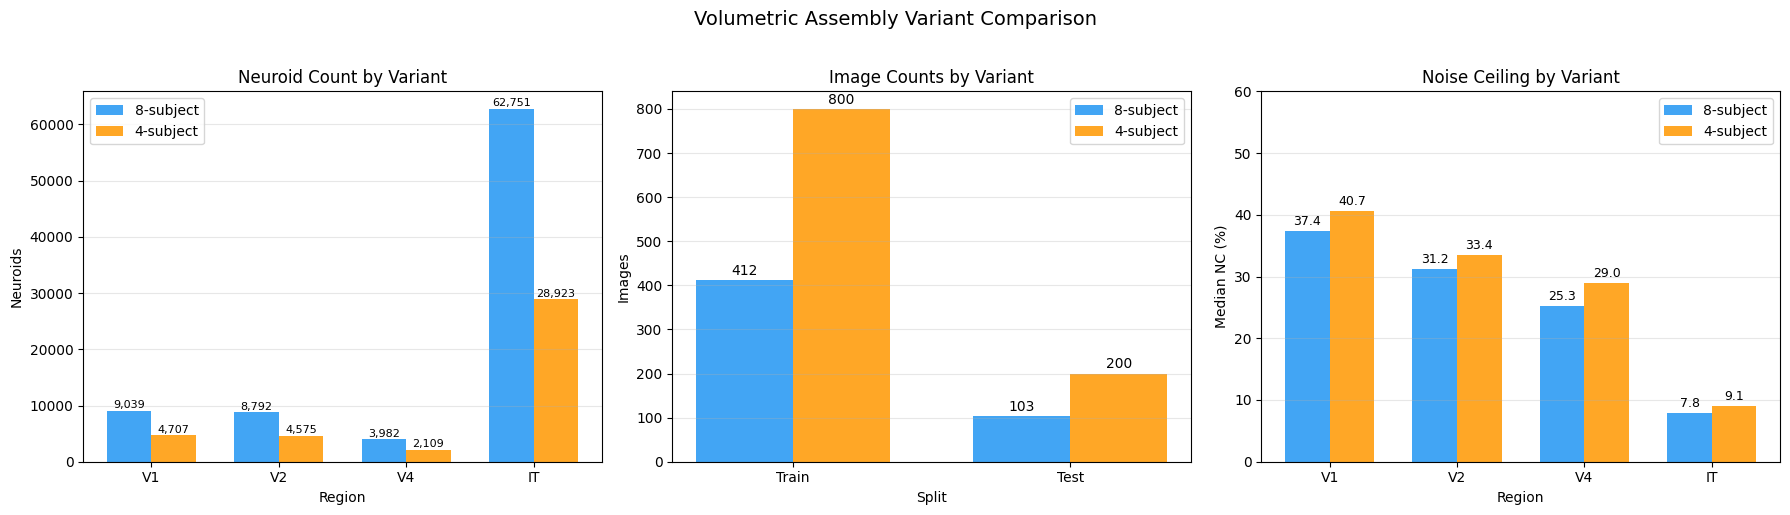

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

x = np.arange(len(REGIONS))
width = 0.35

# Panel 1: Neuroid counts
ax = axes[0]
c8 = [int((train_8s.coords['region'].values == r).sum()) for r in REGIONS]
c4 = [int((train_4s.coords['region'].values == r).sum()) for r in REGIONS]
bars1 = ax.bar(x - width/2, c8, width, label='8-subject', color='#2196F3', alpha=0.85)
bars2 = ax.bar(x + width/2, c4, width, label='4-subject', color='#FF9800', alpha=0.85)
ax.set_xlabel('Region')
ax.set_ylabel('Neuroids')
ax.set_title('Neuroid Count by Variant')
ax.set_xticks(x)
ax.set_xticklabels(REGIONS)
ax.legend()
ax.grid(axis='y', alpha=0.3)
for bar in bars1 + bars2:
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 100,
            f'{int(bar.get_height()):,}', ha='center', va='bottom', fontsize=8)

# Panel 2: Train/test image counts
ax = axes[1]
n_test_8 = len(set(assemblies['8-subject']['test'].coords['stimulus_id'].values))
n_test_4 = len(set(assemblies['4-subject']['test'].coords['stimulus_id'].values))
categories = ['Train', 'Test']
vals_8 = [train_8s.sizes['presentation'], n_test_8]
vals_4 = [train_4s.sizes['presentation'], n_test_4]
x2 = np.arange(len(categories))
bars1 = ax.bar(x2 - width/2, vals_8, width, label='8-subject', color='#2196F3', alpha=0.85)
bars2 = ax.bar(x2 + width/2, vals_4, width, label='4-subject', color='#FF9800', alpha=0.85)
ax.set_xlabel('Split')
ax.set_ylabel('Images')
ax.set_title('Image Counts by Variant')
ax.set_xticks(x2)
ax.set_xticklabels(categories)
ax.legend()
ax.grid(axis='y', alpha=0.3)
for bar in bars1 + bars2:
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 5,
            str(int(bar.get_height())), ha='center', va='bottom', fontsize=10)

# Panel 3: Median NC per region
ax = axes[2]
nc8 = [float(np.nanmedian(train_8s.coords['nc_testset'].values[
    train_8s.coords['region'].values == r])) for r in REGIONS]
nc4 = [float(np.nanmedian(train_4s.coords['nc_testset'].values[
    train_4s.coords['region'].values == r])) for r in REGIONS]
bars1 = ax.bar(x - width/2, nc8, width, label='8-subject', color='#2196F3', alpha=0.85)
bars2 = ax.bar(x + width/2, nc4, width, label='4-subject', color='#FF9800', alpha=0.85)
ax.set_xlabel('Region')
ax.set_ylabel('Median NC (%)')
ax.set_title('Noise Ceiling by Variant')
ax.set_xticks(x)
ax.set_xticklabels(REGIONS)
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 60)
for bar in bars1 + bars2:
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
            f'{bar.get_height():.1f}', ha='center', va='bottom', fontsize=9)

fig.suptitle('Volumetric Assembly Variant Comparison', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

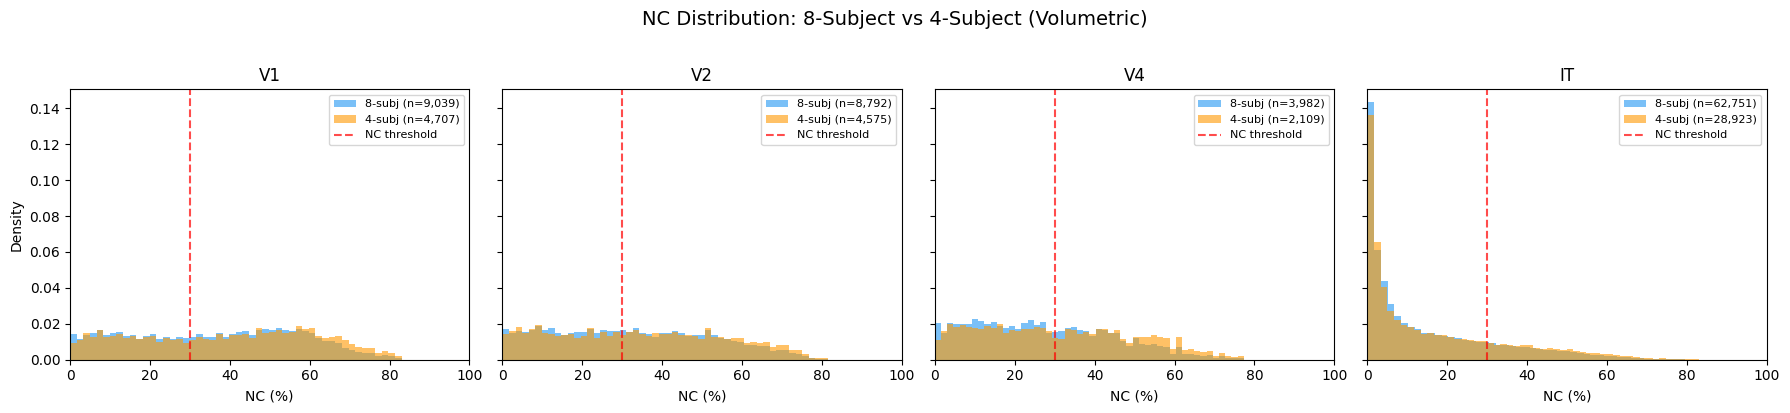

In [8]:
fig, axes = plt.subplots(1, 4, figsize=(18, 4), sharey=True)

for i, region in enumerate(REGIONS):
    ax = axes[i]
    nc_8 = train_8s.coords['nc_testset'].values[
        train_8s.coords['region'].values == region]
    nc_4 = train_4s.coords['nc_testset'].values[
        train_4s.coords['region'].values == region]

    ax.hist(nc_8, bins=50, alpha=0.6, color='#2196F3',
            label=f'8-subj (n={len(nc_8):,})', density=True)
    ax.hist(nc_4, bins=50, alpha=0.6, color='#FF9800',
            label=f'4-subj (n={len(nc_4):,})', density=True)
    ax.axvline(x=30, color='red', linestyle='--', alpha=0.7, label='NC threshold')
    ax.set_title(region, fontsize=12)
    ax.set_xlabel('NC (%)')
    if i == 0:
        ax.set_ylabel('Density')
    ax.legend(fontsize=8)
    ax.set_xlim(0, 100)

fig.suptitle('NC Distribution: 8-Subject vs 4-Subject (Volumetric)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 5. Summary

In [9]:
print('Volumetric Benchmark Smoke Test Summary')
print('=' * 60)
print(f'Assemblies loaded: 8-subject and 4-subject')
print(f'  8-subject train: {assemblies["8-subject"]["train"].shape}')
print(f'  4-subject train: {assemblies["4-subject"]["train"].shape}')
print(f'Benchmarks scored: {len(results_df)} (2 variants x 4 regions x 2 metrics)')
print()

for label in ['8-subject', '4-subject']:
    subset = results_df[results_df['variant'] == label]
    print(f'{label} (ceiling-normalized):')
    print(f'  {"Region":>6s}  {"Ridge":>8s}  {"RDM":>8s}')
    for region in REGIONS:
        ridge_row = subset[(subset['region'] == region) & (subset['metric'] == 'ridge')]
        rdm_row = subset[(subset['region'] == region) & (subset['metric'] == 'rdm')]
        r_val = ridge_row['normalized'].values[0] if len(ridge_row) else float('nan')
        d_val = rdm_row['normalized'].values[0] if len(rdm_row) else float('nan')
        print(f'  {region:>6s}  {r_val:>8.4f}  {d_val:>8.4f}')
    print()

print('All checks passed.')

Volumetric Benchmark Smoke Test Summary
Assemblies loaded: 8-subject and 4-subject
  8-subject train: (412, 84564, 1)
  4-subject train: (800, 40314, 1)
Benchmarks scored: 16 (2 variants x 4 regions x 2 metrics)

8-subject (ceiling-normalized):
  Region     Ridge       RDM
      V1    0.4019    0.4545
      V2    0.4366    0.3671
      V4    0.3482    0.3281
      IT    0.2870    0.3779

4-subject (ceiling-normalized):
  Region     Ridge       RDM
      V1    0.3965    0.5601
      V2    0.4080    0.4533
      V4    0.3208    0.4259
      IT    0.2599    0.4190

All checks passed.


In [10]:
for label in assemblies:
    assemblies[label]['train'].close()
    assemblies[label]['test'].close()
print('All assemblies closed.')

All assemblies closed.
